In [1]:
import numpy as np
import pandas as pd
from imageio import imread
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os
import cv2
from common import *
from models import *
import tensorflow as tf
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split


print(f"Root directory: {os.getcwd()}")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

#%matplotlib

Root directory: c:\Users\andre\Dropbox\FYS-STK4155_projects\FYS-STK4155 - Project2\FYS-STK4155-Prj2_report\code


# Global variables

In [2]:
SEED_VALUE = 70707070
np.random.seed(SEED_VALUE)
SAVE_FIGURES = False

# Reading data and resizing

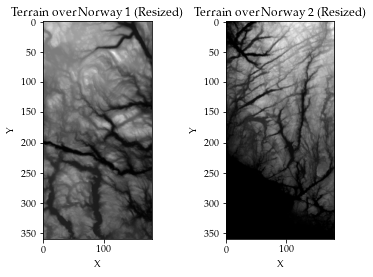

In [3]:
# Load the terrain
terrain1_file = "SRTM_data_Norway_1.tif"
terrain2_file = "SRTM_data_Norway_2.tif"
terrain1 =  imread(f'{INPUT_DATA}{terrain1_file}')
terrain2 = imread(f'{INPUT_DATA}{terrain2_file}')

# Resizing the image
rescale_factor = 0.1
y_size = int(terrain1.shape[0] * rescale_factor)
x_size = int(terrain1.shape[1] * rescale_factor)
terrain1Resized = cv2.resize(terrain1, (x_size, y_size))
terrain2Resized = cv2.resize(terrain2, (x_size, y_size))

# Plotting terrain
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text("Terrain over Norway 1 (Resized)")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1Resized, cmap='gray')
ax2.title.set_text("Terrain over Norway 2 (Resized)")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain2Resized, cmap='gray')

if SAVE_FIGURES:
    plt.savefig(f"{REPORT_FIGURES}{EX_A}terrain_data_resized.pdf")
plt.show()

# Creating image patches and Terrain data selection

In [4]:
nXpatches = 3; nYpatches=6
y_steps = int(terrain2Resized.shape[0] / nYpatches); print(y_steps)
x_steps = int(terrain2Resized.shape[1] / nXpatches); print(x_steps)

patches_1 = create_img_patches(terrain1Resized, y_steps, x_steps)
if SAVE_FIGURES:
    fig1 = plotTerrainPatches(patches_1, nYpatches, nXpatches, plotTitle="Terrain1 patches")
    plt.savefig(f"{REPORT_FIGURES}{EX_A}Terrain1_patches.pdf")
    plt.show()

patches_2 = create_img_patches(terrain2Resized, y_steps, x_steps)
if SAVE_FIGURES:
    fig2 = plotTerrainPatches(patches_2, nYpatches, nXpatches, plotTitle="Terrain2 patches")
    plt.savefig(f"{REPORT_FIGURES}{EX_A}Terrain2_patches.pdf")
    plt.show()

# Choosing two interesting terrain patches
img1 = patches_1[2]
img2 = patches_2[5]
x1, y1, z1 = createTerrainData(img1)
x2, y2, z2 = createTerrainData(img2)

# Constructing the terrain data
terrain_data = 1
if terrain_data == 1: # Choosing terrain1*
    x, y, z = x1, y1, z1.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z1

elif terrain_data == 2: # Choosing terrain2
    x, y, z = x2, y2, z2.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z2
    
z_flat = z.ravel(); z_flat = z_flat.reshape(-1,1)

60
60


# Real Terrain data

In [5]:
np.random.seed(4155)

degree = 1
X = create_X(x,y, degree)
X = X[:,1:]

X_train, X_test, t_train, t_test = train_test_split(X, z_flat, test_size=0.2, shuffle=True)

X_train, X_test = standard_scaling(X_train, X_test)
t_train, t_test = standard_scaling(t_train, t_test)

lr_upper_limit = learning_rate_upper_limit(X_train)

Upper limit learing rate: 0.9900859685598113


# Comparing own NN implementation against sklearn and tensorflow

In [6]:
# Parameters
epochs = 100
batch_size = 100
eta = 0.001
nbf_features = X_train.shape[1]
use_l2 = True
lmb = 0.00001
hidden_size = 25
act_func = "sigmoid"

In [7]:
own_model, sk_model, tf_model = NN_regression_comparison(eta, nbf_features, 
                                                         batch_size, epochs, 
                                                         X_test=X_test.copy(), 
                                                         t_test=t_test.copy(),
                                                         lmb=lmb, hidden_size=hidden_size, 
                                                         act_func=act_func,
                                                         )
# Own model
_, _ = own_model.fit(X_train.copy(), t_train.copy(), batch_size=batch_size, epochs=epochs, verbose=False)
t_hat_test_own = own_model.predict(X_test.copy())
print("MSE using own implemented NN:",MSE(t_test, t_hat_test_own),"\n")

# SK learn
sk_model.fit(X_train.copy(), t_train.copy().ravel())
t_hat_test_sk_model = sk_model.predict(X_test.copy())
print("MSE using SK learn NN:", MSE(t_test, t_hat_test_sk_model),"\n")

# Tensorflow 
tf_model.fit(X_train.copy(), t_train.copy(), epochs=epochs,  batch_size=batch_size, verbose=0)
t_hat_test_tf = tf_model.predict(X_test.copy())
print("MSE using tensorflow NN:",MSE(t_test, t_hat_test_tf))

MSE using own implemented NN: 1.044755220945635 

MSE using SK learn NN: 0.8731620709349366 

MSE using tensorflow NN: 0.9021899392759142


# Grid search using simple architecture

### Parameters

In [8]:
epochs = 100
batch_size = 100
nbf_features = X_train.shape[1]
act_func = "sigmoid"
# print(np.linspace(0.00001, 0.01, 10))
# print(np.logspace(-2, -5, 10))
# print(np.logspace(-1, -5, 10))

### Grid search

0it [00:00, ?it/s]

Creating models using 8 neurons in first hidden layer
New best MSE own NN: 0.945
New best MSE tensorflow: 0.7984
New best MSE own NN: 0.9383
New best MSE own NN: 0.8827
New best MSE tensorflow: 0.7713
New best MSE own NN: 0.8695


1it [03:42, 222.16s/it]

Creating models using 16 neurons in first hidden layer
New best MSE own NN: 0.8514
New best MSE own NN: 0.8367


2it [09:09, 284.27s/it]

Creating models using 32 neurons in first hidden layer
New best MSE own NN: 0.8188


3it [14:58, 299.59s/it]


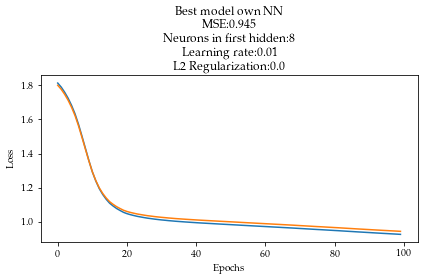

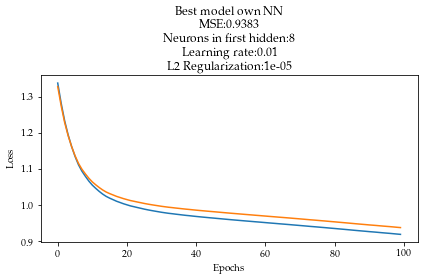

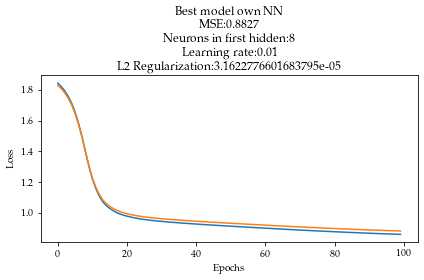

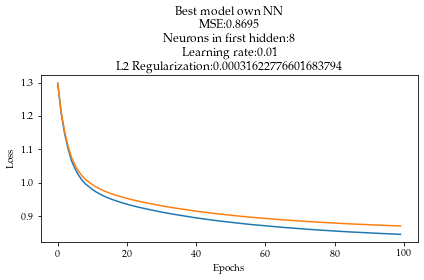

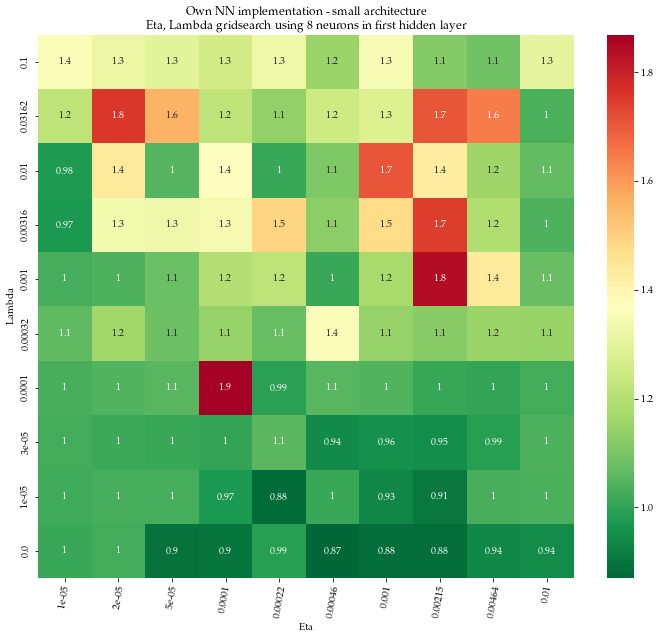

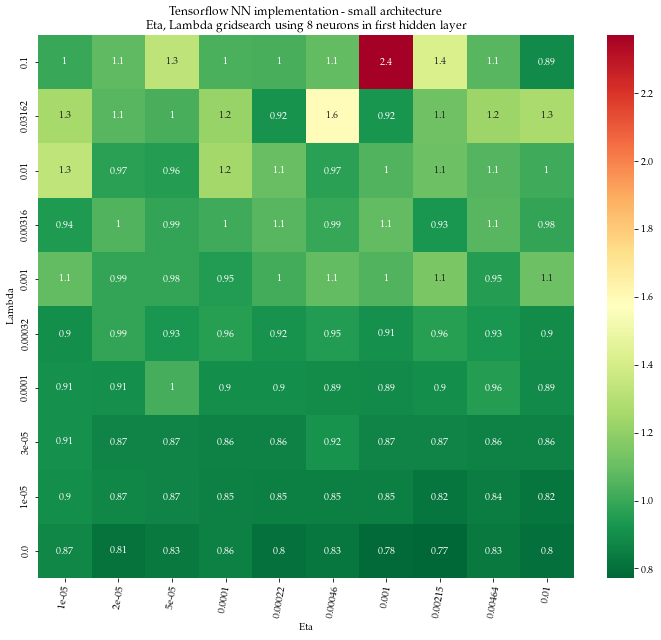

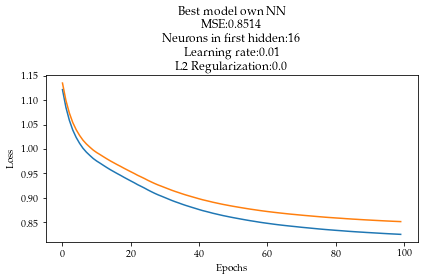

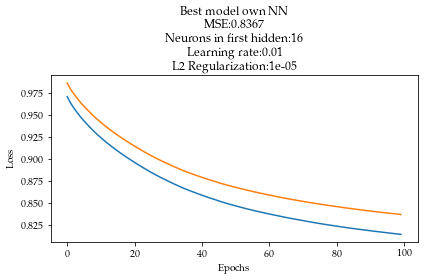

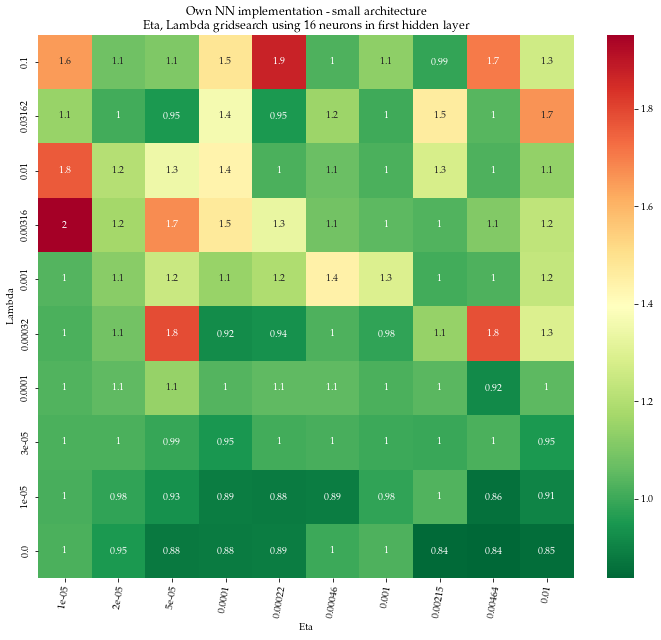

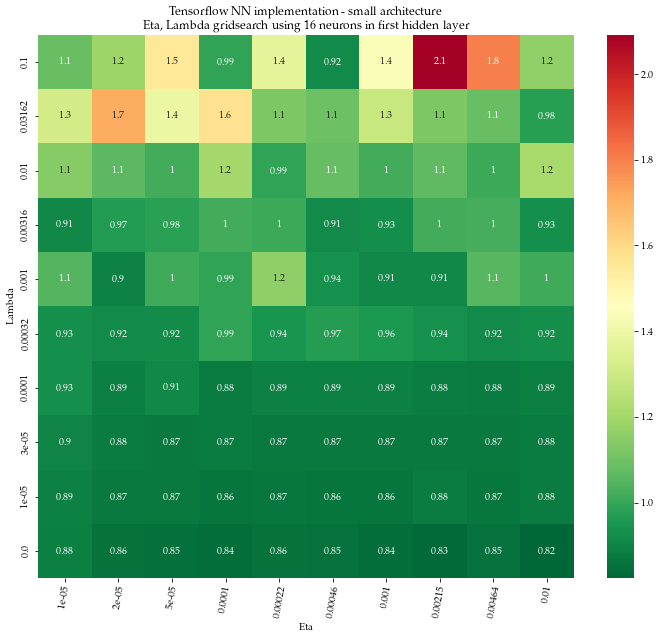

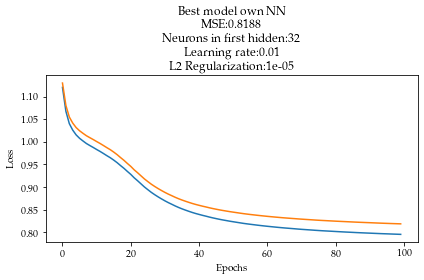

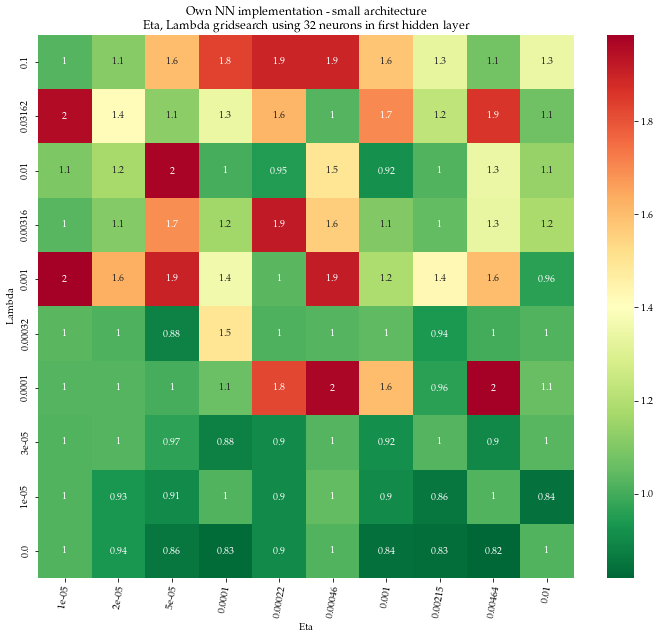

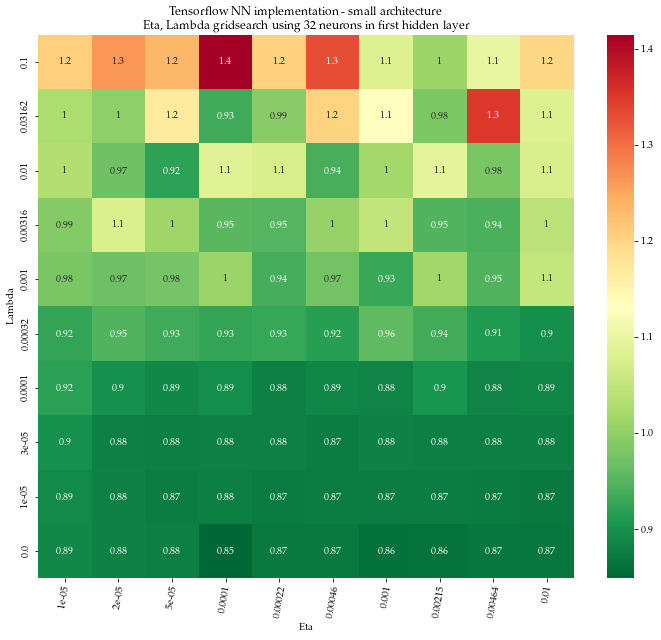

In [9]:
hidden_sizes = np.array([8, 16, 32, 48])
eta_list = np.logspace(-2, -5, 10)
lmb_list = np.concatenate([np.zeros(1),np.logspace(-5, -1, 9)], axis=0)
heatmap_mtrx_MSE = np.zeros(shape=(hidden_sizes.shape[0], eta_list.shape[0], lmb_list.shape[0]))
heatmap_mtrx_MSE_tf = np.zeros_like(heatmap_mtrx_MSE)
heatmap_mtrx_R2 = np.zeros_like(heatmap_mtrx_MSE)
heatmap_mtrx_R2_tf = np.zeros_like(heatmap_mtrx_MSE)

parameters_best_MSE = {"best_MSE" : np.Inf, "neurons_first_hidden":0, "learning_rate":0, "lambda":0}
parameters_best_MSE_tf = {"best_MSE" : np.Inf, "neurons_first_hidden":0, "learning_rate":0, "lambda":0}
parameters_best_R2 = {"best_R2" : np.Inf, "neurons_first_hidden":0, "learning_rate":0, "lambda":0}
parameters_best_R2_tf = {"best_R2" : np.Inf, "neurons_first_hidden":0, "learning_rate":0, "lambda":0}
best_models = {"own_NN":None, "tf_NN":None}

# Grid search on eta and lambda 
for n, hidden_size in tqdm(enumerate(hidden_sizes)):
    print(f"Creating models using {hidden_size} neurons in first hidden layer")
    for y, eta in enumerate(eta_list):
        for x, lmb in enumerate(lmb_list):
            own_model, tf_model = NN_simple_architecture(eta, nbf_features,
                                                         problem_type="regression",
                                                         X_test=X_test.copy(), t_test=t_test.copy(),
                                                         lmb=lmb, 
                                                         hidden_size=hidden_size, 
                                                         act_func=act_func)
            # Own model
            train_losses, test_losses = own_model.fit(X_train.copy(), t_train.copy(), batch_size=batch_size, epochs=epochs, verbose=False)
            t_hat_test_own = own_model.predict(X_test.copy())
            
            MSE_val = np.around(MSE(t_test, t_hat_test_own), decimals=4)
            heatmap_mtrx_MSE[n,y,x] = MSE_val
            if parameters_best_MSE["best_MSE"] > MSE_val:
                print(f"New best MSE own NN: {MSE_val}")
                best_models["own_NN"] = own_model
                parameters_best_MSE["best_MSE"] = MSE_val
                parameters_best_MSE["neurons_first_hidden"] = hidden_size
                parameters_best_MSE["learning_rate"] = eta
                parameters_best_MSE["lambda"] = lmb
                df = pd.DataFrame().from_dict(parameters_best_MSE, orient='index')
                df.to_csv(f"{REPORT_DATA}{EX_B}own_NN_best_training_small.csv")
                
                plt.figure()
                plt.plot(np.arange(epochs), train_losses)
                plt.plot(np.arange(epochs), test_losses)
                plt.title(f"Best model own NN\nMSE:{MSE_val}\nNeurons in first hidden:{hidden_size}\nLearning rate:{eta}\nL2 Regularization:{lmb}", )
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.tight_layout()
                plt.savefig(f"{REPORT_FIGURES}{EX_B}own_NN_best_training_small.pdf")
            
            R2_val = np.around(R2(t_test, t_hat_test_own), decimals=4)
            heatmap_mtrx_R2[n,y,x] = R2_val
            
            # Tensorflow
            tf_model.fit(X_train.copy(), t_train.copy(), batch_size=batch_size, epochs=epochs, verbose=0)
            t_hat_test_tf = tf_model.predict(X_test.copy())
            
            MSE_val_tf = np.around(MSE(t_test, t_hat_test_tf), decimals=4)
            heatmap_mtrx_MSE_tf[n, y,x] = MSE_val_tf

            if parameters_best_MSE_tf["best_MSE"] > MSE_val_tf:
                print(f"New best MSE tensorflow: {MSE_val_tf}")
                parameters_best_MSE_tf["best_MSE"] = MSE_val_tf
                parameters_best_MSE_tf["neurons_first_hidden"] = hidden_size
                parameters_best_MSE_tf["learning_rate"] = eta
                parameters_best_MSE_tf["lambda"] = lmb
                best_models["tf_NN"] = tf_model
            
            R2_val_tf = np.around(R2(t_test, t_hat_test_tf), decimals=4)
            heatmap_mtrx_R2_tf[n, y,x] = R2_val_tf
            

            
    plot_save_NN_results(hidden_size=hidden_size, model_size="small", eta_list=eta_list, lmb_list=lmb_list, 
                         heatmap_mtrx=heatmap_mtrx_MSE[n, :,:], heatmap_mtrx_tf=heatmap_mtrx_MSE_tf[n, :,:])

# Grid search using large architecture

### Parameters

In [10]:
epochs = 100
batch_size = 100
nbf_features = X_train.shape[1]
act_func = "sigmoid"
# print(np.linspace(0.00001, 0.01, 10))
# print(np.logspace(-2, -5, 10))
# print(np.logspace(-1, -5, 10))

### Grid search

0it [00:00, ?it/s]

Creating models using 8 neurons in first hidden layer
New best MSE own NN: 1.0241
New best MSE tensorflow: 1.0202
New best MSE own NN: 1.0106
New best MSE tensorflow: 1.0197
New best MSE tensorflow: 1.0185


1it [07:28, 448.85s/it]

Creating models using 16 neurons in first hidden layer
New best MSE tensorflow: 1.0167
New best MSE own NN: 1.0027
New best MSE own NN: 0.9294
New best MSE own NN: 0.9243


2it [17:30, 538.70s/it]

Creating models using 32 neurons in first hidden layer
New best MSE own NN: 0.8113
New best MSE own NN: 0.8006
New best MSE tensorflow: 1.0138


3it [37:11, 743.82s/it]


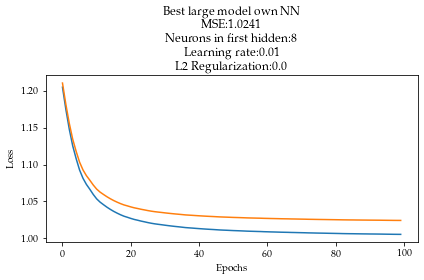

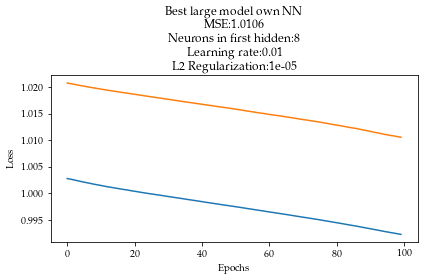

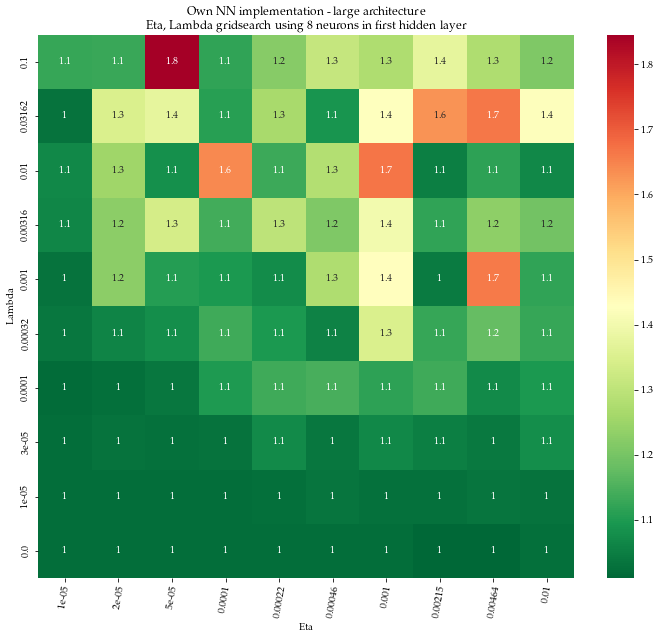

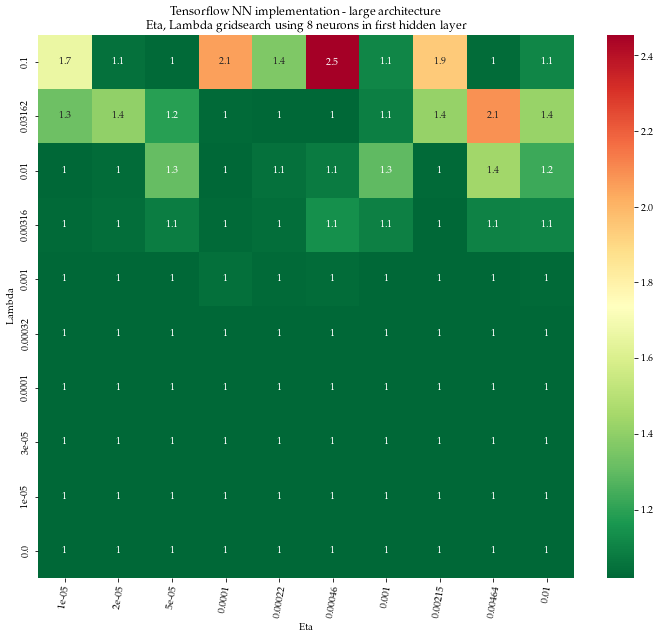

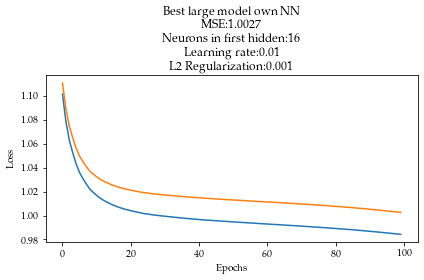

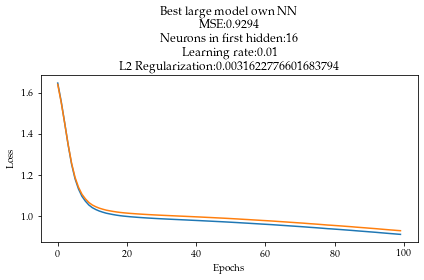

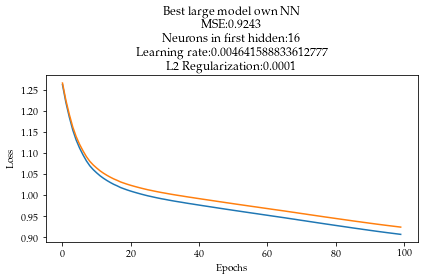

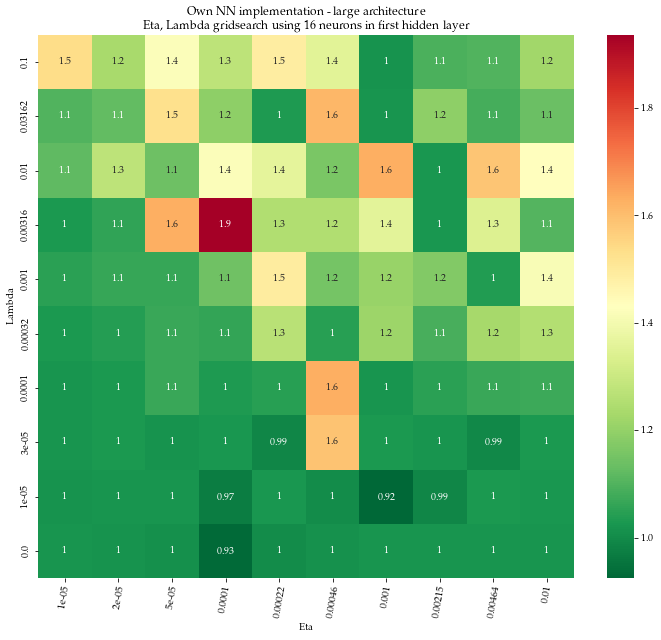

In [11]:
hidden_sizes = np.array([8, 16, 32, 48])
eta_list = np.logspace(-2, -5, 10)
lmb_list = np.concatenate([np.zeros(1),np.logspace(-5, -1, 9)], axis=0)
heatmap_mtrx_MSE = np.zeros(shape=(hidden_sizes.shape[0], eta_list.shape[0], lmb_list.shape[0]))
heatmap_mtrx_MSE_tf = np.zeros_like(heatmap_mtrx_MSE)
heatmap_mtrx_R2 = np.zeros_like(heatmap_mtrx_MSE)
heatmap_mtrx_R2_tf = np.zeros_like(heatmap_mtrx_MSE)

parameters_best_MSE = {"best_MSE" : np.Inf, "neurons_first_hidden":0, "learning_rate":0, "lambda":0}
parameters_best_MSE_tf = {"best_MSE" : np.Inf, "neurons_first_hidden":0, "learning_rate":0, "lambda":0}
parameters_best_R2 = {"best_R2" : np.Inf, "neurons_first_hidden":0, "learning_rate":0, "lambda":0}
parameters_best_R2_tf = {"best_R2" : np.Inf, "neurons_first_hidden":0, "learning_rate":0, "lambda":0}
best_models = {"own_NN":None, "tf_NN":None}

# Grid search on eta and lambda 
for n, hidden_size in tqdm(enumerate(hidden_sizes)):
    print(f"Creating models using {hidden_size} neurons in first hidden layer")
    for y, eta in enumerate(eta_list):
        for x, lmb in enumerate(lmb_list):
            own_model, tf_model = NN_large_architecture(eta, nbf_features,
                                                        problem_type="regression",
                                                        X_test=X_test.copy(), t_test=t_test.copy(),
                                                        lmb=lmb, 
                                                        hidden_size=hidden_size, 
                                                        act_func=act_func)
            # Own model
            train_losses, test_losses = own_model.fit(X_train.copy(), t_train.copy(), batch_size=batch_size, epochs=epochs, verbose=False)
            t_hat_test_own = own_model.predict(X_test.copy())
            
            MSE_val = np.around(MSE(t_test, t_hat_test_own), decimals=4)
            heatmap_mtrx_MSE[n,y,x] = MSE_val
            if parameters_best_MSE["best_MSE"] > MSE_val:
                print(f"New best MSE own NN: {MSE_val}")
                best_models["own_NN"] = own_model
                parameters_best_MSE["best_MSE"] = MSE_val
                parameters_best_MSE["neurons_first_hidden"] = hidden_size
                parameters_best_MSE["learning_rate"] = eta
                parameters_best_MSE["lambda"] = lmb
                df = pd.DataFrame().from_dict(parameters_best_MSE, orient='index')
                df.to_csv(f"{REPORT_DATA}{EX_B}own_NN_best_training_large.csv")
                
                plt.figure()
                plt.plot(np.arange(epochs), train_losses)
                plt.plot(np.arange(epochs), test_losses)
                plt.title(f"Best large model own NN\nMSE:{MSE_val}\nNeurons in first hidden:{hidden_size}\nLearning rate:{eta}\nL2 Regularization:{lmb}", )
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.tight_layout()
                plt.savefig(f"{REPORT_FIGURES}{EX_B}own_NN_best_training_large.pdf")
            
            R2_val = np.around(R2(t_test, t_hat_test_own), decimals=4)
            heatmap_mtrx_R2[n,y,x] = R2_val
            
            # Tensorflow
            tf_model.fit(X_train.copy(), t_train.copy(), batch_size=batch_size, epochs=epochs, verbose=0)
            t_hat_test_tf = tf_model.predict(X_test.copy())
            
            MSE_val_tf = np.around(MSE(t_test, t_hat_test_tf), decimals=4)
            heatmap_mtrx_MSE_tf[n, y,x] = MSE_val_tf

            if parameters_best_MSE_tf["best_MSE"] > MSE_val_tf:
                print(f"New best MSE tensorflow: {MSE_val_tf}")
                parameters_best_MSE_tf["best_MSE"] = MSE_val_tf
                parameters_best_MSE_tf["neurons_first_hidden"] = hidden_size
                parameters_best_MSE_tf["learning_rate"] = eta
                parameters_best_MSE_tf["lambda"] = lmb
                best_models["tf_NN"] = tf_model
            
            R2_val_tf = np.around(R2(t_test, t_hat_test_tf), decimals=4)
            heatmap_mtrx_R2_tf[n, y,x] = R2_val_tf
            

            
    plot_save_NN_results(hidden_size=hidden_size, model_size="large", eta_list=eta_list, lmb_list=lmb_list, 
                         heatmap_mtrx=heatmap_mtrx_MSE[n, :,:], heatmap_mtrx_tf=heatmap_mtrx_MSE_tf[n, :,:])

# Tests

# XOR classification test
The following code checks that a Fixed neural net is able to correctly classify the XOR problem

In [ ]:
"""np.random.seed(4155)
X = np.array([[1, 0],
              [0, 1],
              [1, 1],
              [0, 0]])

hidden1 = Fixed_layer(nbf_inputs=2, nbf_outputs=2, weights=np.array([[1,1],[1,1]]), bias=np.array([-1.5, -0.5]), activation_function=binary_classifier)
output = Fixed_layer(nbf_inputs=2, nbf_outputs=1, weights=np.array([-1,1]), bias=np.array([-0.5]), activation_function=binary_classifier)

model = NeuralNetwork()
model.add(hidden1)
model.add(output)

y_hat = model.predict(X)
print(f"y_hat: {y_hat}")"""

# Neural Net on XOR problem

In [ ]:
#np.random.seed(4155)
X_train = np.array([[1., 0.],
              [1., 1.],
              
              [0., 1.]])

X_test = np.array([[0., 0.]]) 

t = np.array([[1.,0.,1.]]).reshape(-1,1)

#hidden1 = Layer(nbf_inputs=2, nbf_outputs=4, activation_function=relu)
#hidden2 = Layer(nbf_inputs=hidden1.output, nbf_outputs=16)
hidden1 = Layer(nbf_inputs=2, nbf_outputs=2, activation=relu, name="hidden1")
output = Layer(nbf_inputs=hidden1.output, nbf_outputs=1, name="output")

model2 = NeuralNetwork()
model2.add(hidden1)
model2.add(output)

epochs = 100
batch_size = 2
model2.train_model(X_train, t, batch_size=batch_size, epochs=epochs)
y_hat = model2.predict(X_test)
print(y_hat)

In [ ]:
from sklearn.neural_network import MLPRegressor
clf = MLPRegressor(hidden_layer_sizes=(2,), max_iter=100, solver="sgd",learning_rate_init=0.001, activation="relu")
for i in range(10):
    clf.fit(X, t.flatten())
print(clf.predict(X_test))

# Tensorflow model

In [ ]:
# Parameters
epochs = 100
batch_size = 2
eta = 0.001

# Creating the model
tf_model = tf.keras.Sequential()
tf_model.add(tf.keras.layers.Input(shape=(2,)))
tf_model.add(tf.keras.layers.Dense(2, activation='relu'))
tf_model.add(tf.keras.layers.Dense(1))
tf_model.compile(loss='mse', optimizer=tf.optimizers.SGD(learning_rate=eta))


# Model training
tf_model.fit(X_train, t, epochs=epochs,  batch_size=batch_size, verbose=1)

# Model predictions
y_hat = tf_model.predict(X_test)
print(y_hat)

In [ ]:
np.random.seed(4155)
X_train = np.array([[1., 0.]])
t_train = np.array([[1.]]).reshape(-1,1)


hidden1 = Fixed_layer(nbf_inputs=2, nbf_outputs=2, weights=np.array([[1.,0.],[1.,0.]]), bias=np.array([0.01, 0.01]), activation="sigmoid")
output = Fixed_layer(nbf_inputs=2, nbf_outputs=1, weights=np.array([[1.],[0.]]), bias=np.array([0.01]), activation="sigmoid")

model = NeuralNetwork(learning_rate=1.0)
model.add(hidden1)
model.add(output)


pred = model.predict(X_train)
print(pred)

In [ ]:
print(model.sequential_layers[0].z)
print(model.sequential_layers[0].a)

In [ ]:
print(model.sequential_layers[-1].z)
print(model.sequential_layers[-1].a)

In [ ]:
print("X_train.shape:",X_train.shape)
print("t_train.shape:",t_train.shape)
model.train_model(X_train, t_train, epochs=1, batch_size=1)

In [ ]:
print(sigmoid(1+0.01) + 0.01)
print(sigmoid(sigmoid(1+0.01) + 0.01))
print(sigmoid(1+0.01) + 0.01)


print(sigmoid(1+0.01)*(1-sigmoid(1+0.01)))

print(0.3323*0.1957)

print(-(sigmoid(+0.01) * 0.3323 ))

In [ ]:
a = np.arange(9)
print(a)

b = a <= 3
print(b)